In [1]:
#Import packages and set pylab inline to plots show up in the notebook
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from statsmodels.formula.api import ols, glsar
import statsmodels.formula.api as sm
from matplotlib.font_manager import FontProperties
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from yellowbrick.classifier import ROCAUC, ClassificationReport

Populating the interactive namespace from numpy and matplotlib


In [2]:
#bring in data
df1 = pd.read_csv('seds_all_states_long.csv')
#sort on state
df1 = df1.sort_values(['state'])
#drop 0 columns because this dataframe will be used as the master for total generation, so zeros will get summed out
#group by year and state, so we can see everything in chronological order
df1 = df1[df1.value != 0].groupby(['year','state']).sum()
df1.index.names = ['year','state']
df1.columns = ['sumgen']

#make some copies that we can play around with and graph for meaning
copy1 = df1.copy()
copy2 = df1.copy()


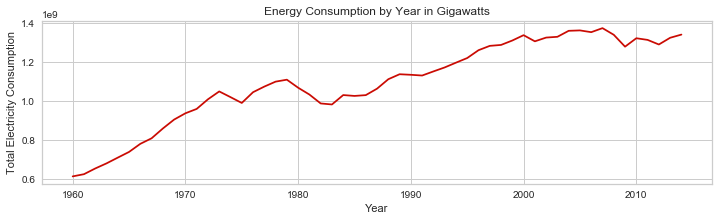

In [3]:
yearly_cons = df1.reset_index()
yearly_cons.head()
yearly_cons=yearly_cons.groupby('year').sum()

fig, axes = plt.subplots(figsize = (12,3))

axes.plot(yearly_cons, 'r')
axes.set_xlabel('Year')
axes.set_ylabel('Total Electricity Consumption')
axes.set_title('Energy Consumption by Year in Gigawatts');
plt.show()


In [4]:
#Get yearly consumption by state, and pair that with total consumption for the year
yearly_cons = yearly_cons.reset_index()
copy2 = copy2.reset_index()

percentage_copy = copy2.merge(yearly_cons, how = 'outer', on = ['year'])

#make a new row that shows what percent of generation the given state was during every year
percentage_copy['Percent of Yearly Consumption'] = 100*percentage_copy['sumgen_x']/percentage_copy['sumgen_y']

#Unsurprisingly California, Texas, New York, and Pennsylvania use a lot of energy

In [5]:
sorted_states = percentage_copy.sort_values(['year','Percent of Yearly Consumption','year'])

#break up generation by state and by year. This will allow us to make area graphs showing not
#only the change in consumption over time, but which states grew and and at what rate.
tot_gen_by_st = df1.unstack('state')

tot_gen_by_st.columns= tot_gen_by_st.columns.droplevel(0)


tot_gen_by_st.head()
st_gen = tot_gen_by_st
st_gen = st_gen.reset_index()

## The first dataframe makes it easy to see how states contribute to the mix over a longer time frame, but the second one will give us a nice breakdown of generation type/fuel type, which is more what we're interested in. 

In [47]:
df2 = pd.read_excel('annual_generation_state.xls', skiprows = 1)
df2.columns = ['year','state','type','input_type','gen_by_type']
df2.head()

,year,state,type,input_type,gen_by_type
0,1990,AK,Total Electric Power Industry,Total,5599506.0
1,1990,AK,Total Electric Power Industry,Coal,510573.0
2,1990,AK,Total Electric Power Industry,Hydroelectric Conventional,974521.0
3,1990,AK,Total Electric Power Industry,Natural Gas,3466261.0
4,1990,AK,Total Electric Power Industry,Petroleum,497116.0


### We're gonna quickly figure out which generation is biggest in each state as a sum of all years. Because our data is relatively short term, I think this will give us an idea of what direction a state is taking in regards to its energy mix.

In [7]:
#Make a list of the unique state names
state_list = df2.state.unique()

#Group the state by state generation up by state and input type
state_gen = df2.set_index('year').groupby(['state','input_type']).sum()
state_gen = state_gen.reset_index()

state_gen = state_gen[state_gen.input_type != 'Total']
#Find each main input type by state and quantity generated by that inout
idx = state_gen.groupby(['state'])['gen_by_type'].transform(max) == state_gen['gen_by_type']
state_gen_type = state_gen[idx]
state_gen_type.head()
st_type = state_gen_type


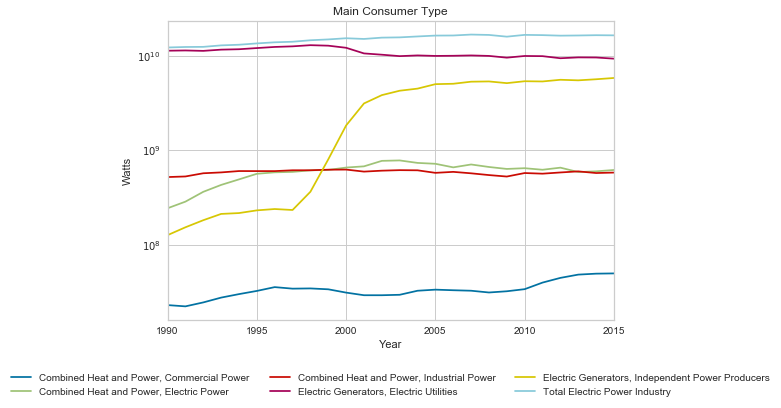

In [8]:
#Shifting gears to see who is consuming the most
#Doing a group by and unstack to isoltate the various main consumer types and turn them into their
#own columns
totals_type = df2.groupby(['year','type']).sum()
totals_type = totals_type.unstack('type')

#Copying this over to a shorter named dataframe we can work with
totals_type.reset_index(0, col_level= 0)
cons = totals_type

#Was running into a problem with a multilevel column index
totals_type.columns= totals_type.columns.droplevel(0)


#Log graph of consumer type
totals_type.plot(logy = True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -.15),
          ncol=3, fancybox=True, shadow=True)
plt.title('Main Consumer Type')
plt.ylabel('Watts')
plt.xlabel('Year')


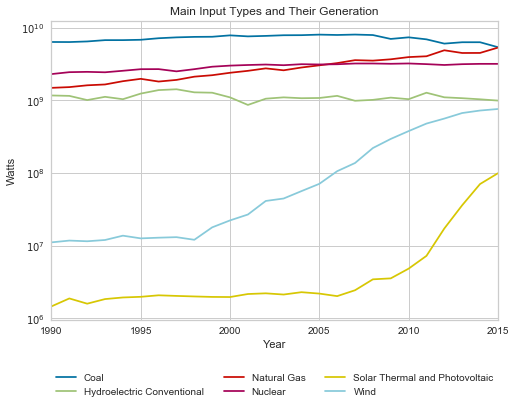

In [9]:
#Now I wanted to get an idea of the various input types and their contributions
df_totals_input = df2.groupby(['year','input_type']).sum()


#Had the same problem with a multi level column index. This did the trick to get rid of the mega-column index.
df_totals_input = df_totals_input.reset_index()
df_totals_input.columns = [c[-1] for c in df_totals_input.columns]


#Rename my columns
df_totals_input.columns = ['year','input_type','gen_amt']
df_totals_input.set_index(['year'])

#pivot to get a dataframe broken up by year and input type
df_totals_input = df_totals_input.pivot(index='year', columns='input_type', values='gen_amt')
inp = df_totals_input

#isolating the main forms of generation. There were others, but they barely contributed to the mix
inputs1 = df_totals_input[['Coal','Hydroelectric Conventional','Natural Gas','Nuclear','Solar Thermal and Photovoltaic','Wind']]

inputs1.plot(logy=True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -.15),
          ncol=3, fancybox=True, shadow=True)
plt.ylabel('Watts')
plt.xlabel('Year')
plt.title('Main Input Types and Their Generation')

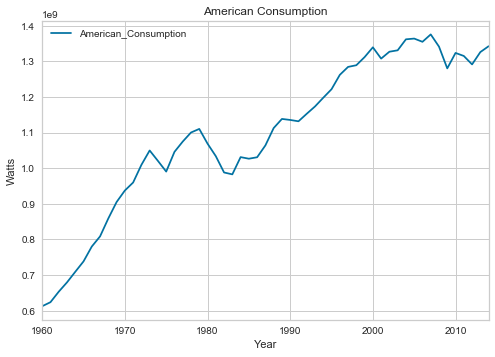

In [10]:
#Quickly plotting American Consumption
USGEN = st_gen.set_index('year')
col_list= list(USGEN)
USGEN['American_Consumption'] = USGEN[col_list].sum(axis=1)
USGEN.reset_index()
USGEN.plot(y = 'American_Consumption')
plt.xlabel('Year')
plt.ylabel('Watts')
plt.title('American Consumption')


In [11]:
#Focus on 6 biggest generation states
#also benificial that they have different political affiliations
ca = st_gen[['year','CA']]
tx = st_gen[['year','TX']]
pa = st_gen[['year','PA']]
wa = st_gen[['year','WA']]
ny = st_gen[['year','NY']]
fl = st_gen[['year','FL']]

In [12]:
#fitting a regression to California. I chose the degree based on how well it fit the
#local maxima and minima of the graph
p, res, _, _, _ = np.polyfit(x = ca.year, y= ca.CA, deg=20, full = True)

In [13]:
yfitca = np.polyval(p,ca.year)


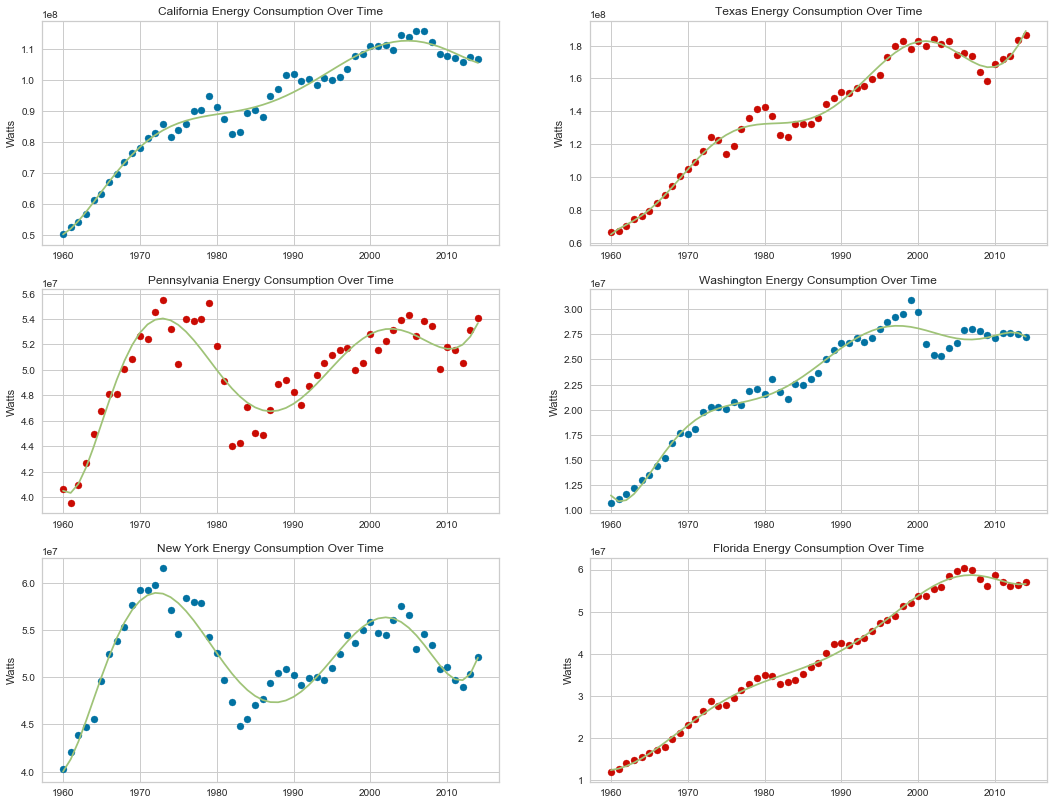

In [14]:
fig = plt.figure(figsize=(18, 14))

#Plotting our fit on top of our data for California
plt.subplot(3,2,1)
plt.scatter(ca.year,ca.CA, label='data', c = 'b')
plt.plot(ca.year,yfitca, label='fit', c = 'g')
plt.title('California Energy Consumption Over Time')
plt.ylabel('Watts')


#Doing it for the other powerhouse state, TEXAS
p, res, _, _, _ = np.polyfit(x = tx.year, y= tx.TX, deg=40, full = True)
yfittx = np.polyval(p,ca.year)
plt.subplot(3,2,2)
plt.scatter(tx.year,tx.TX, label='data', c = 'r')
plt.plot(tx.year,yfittx, label='fit', c = 'g')
plt.title('Texas Energy Consumption Over Time')
plt.ylabel('Watts')

#Pennsylvania has been a historically densely populated, industrial state, so I wanted to take a look
p, res, _, _, _ = np.polyfit(x = pa.year, y= pa.PA, deg=22, full = True)
yfitpa = np.polyval(p,pa.year)
plt.subplot(3,2,3)
plt.scatter(pa.year,pa.PA, label='data', c = 'r')
plt.plot(pa.year,yfitpa, label='fit', c = 'g')
plt.title('Pennsylvania Energy Consumption Over Time')
plt.ylabel('Watts')


#Washington has access to a lot of hydro power, and a very diverse political climate
p, res, _, _, _ = np.polyfit(x = wa.year, y= wa.WA, deg=20, full = True)
yfitwa = np.polyval(p,wa.year)
plt.subplot(3,2,4)
plt.scatter(wa.year,wa.WA, label='data', c = 'b')
plt.plot(wa.year,yfitwa, label='fit', c = 'g')
plt.title('Washington Energy Consumption Over Time')
plt.ylabel('Watts')


#Can't leave out the big apple. Uptick at the end is very intersting, but I think on a less myopic scale,
#we'd likely see a trend downward.
p, res, _, _, _ = np.polyfit(x = ny.year, y= ny.NY, deg=8, full = True)
yfitny = np.polyval(p,ny.year)
plt.subplot(3,2,5)
plt.scatter(ny.year,ny.NY, label='data', c ='b')
plt.plot(ny.year,yfitny, label='fit', c = 'g')
plt.title('New York Energy Consumption Over Time')
plt.ylabel('Watts')


#And of course Florida. Pretty politically moderate state, with a large population.
p, res, _, _, _ = np.polyfit(x = fl.year, y= fl.FL, deg=25, full = True)
yfitfl = np.polyval(p,fl.year)
plt.subplot(3,2,6)
plt.scatter(fl.year,fl.FL, label='data', c = 'r')
plt.plot(fl.year,yfitfl, label='fit', c = 'g')
plt.title('Florida Energy Consumption Over Time')
plt.ylabel('Watts')



It looks like Texas is still very much in a growth phase of energy consumption. When comapred to California, we see that maybe some of California's more liberal constituents are having their desired effect on energy policy. What will be interesting, however, is if the growing energy generators are using more or less renewables every year, i.e. is their growth is at least "clean"?

Plotted 3 more states across the political gamut. A slightly conservative state like Florida is trending down in energy consumption while NY is trending up, regardless of its more lberal voter base. Now I'll dive into the mixes to see if these trends are at least in the right direction.

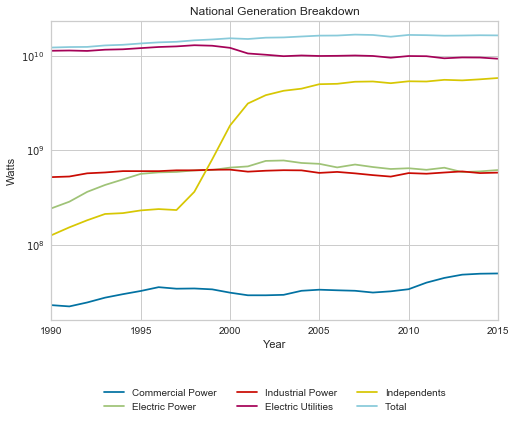

In [15]:
#We'll do a quick piece of analysis on whether who is 
#consuming energy over time has changed or not
cons = cons.reset_index()
cons.columns = ['year','Commercial Power', 'Electric Power','Industrial Power','Electric Utilities','Independents','Total']
cons.head()

cons.plot(x = 'year', logy = True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -.2),
          ncol=3, fancybox=True, shadow=True)
plt.title('National Generation Breakdown')
plt.ylabel('Watts')
plt.xlabel('Year')
plt.show()

#Splitting by decade
cons.year = cons.year//10 * 10


By grouping the years into decades, maybe we'll be able to see if who is actually using power in this country is changing. First we'll graph, and then we'll confirm.

In [16]:
#Quick little forest to see if there is a grouping of decades.
#I want to see if there have been any marked changes in who is using power over time.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()


param_grid = {"max_depth": [None,1,2,3,4],     
         'n_estimators':[1,2,3]
         }

#We want to exclude the decade, and the total consumption
X = cons.iloc[:,1:5]


x_train, x_test, y_train, y_test = train_test_split(X, cons.year, test_size = .3)
rf_cv = GridSearchCV(rf, param_grid, cv = 5)
rf_cv.fit(x_train, y_train)

print("Tuned Forest classifier paramters: {}".format(rf_cv.best_params_))
print("Tuned Forest classifier score: {}".format(rf_cv.best_score_))


/Users/jackdwyer/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Tuned Forest classifier paramters: {'n_estimators': 3, 'max_depth': 3}
Tuned Forest classifier score: 0.944444444444


In [17]:
rf = RandomForestClassifier(max_depth = 2, n_estimators=3)
rf.fit(x_train, y_train)
prediction = rf.predict(x_test)
print('accuracy Score %f' %accuracy_score(y_test,prediction))


#Adding in a confusion matrix and ROC curve 
print('Confusion Matrix:')
print(confusion_matrix(y_test, prediction))


accuracy Score 0.750000
Confusion Matrix:
[[1 0 0]
 [1 4 0]
 [1 0 1]]


Unsurprisingly, our model found the decade split. With a good score for our classifiers and a good accuracy score on our test data, I think we can conclusively say that who is consuming energy changed over the last 2 decades. Also we can visualize what we did using the confusion matrix. Looks like we have 1 misclassification here, which considering how limited the data was, I would say that is exceptional.

In [18]:
inp = pd.read_csv('input_type.csv')
st_type.head()
affil = pd.read_csv('party_aff.csv')

In [19]:
#Dropping some zero values from the beginning, as well as the total generation.

st_type = st_type[st_type.gen_by_type != 0]
st_type = st_type[st_type.state != 'US-TOTAL']
st_type = st_type[st_type.state != 'US-Total']



In [20]:
#Replacing our categorical with a numeric value to facilitate modelling
affil["swing"] = np.where(affil["affiliation"].str.contains("Rep"), 1, 0)

In [21]:
#Merge in our affiliation with our state maximum generation type
st_type = st_type.merge(affil, on='state', how = 'inner')

In [22]:
#dropping the affiliation column that still has our string based categorical variable
st_type = st_type.drop('affiliation',1)

In [23]:
#first we'll see if there is any predictive power in modelling a state's maximum generation type
#on the quantity of that generation. Maybe states who need more power use more fossil fuels?
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
param_grid = {'n_neighbors': [2,3,4,5]}

knn = KNeighborsClassifier()

X = st_type[['gen_by_type','swing']]


x_train, x_test, y_train, y_test = train_test_split(X, st_type.input_type, test_size = .3)
knn_cv = GridSearchCV(knn, param_grid, cv = 5)
knn_cv.fit(x_train, y_train)

print("Tuned Knn classifier paramters: {}".format(knn_cv.best_params_))
print("Tuned Knn classifier score: {}".format(knn_cv.best_score_))





Tuned Knn classifier paramters: {'n_neighbors': 4}
Tuned Knn classifier score: 0.657142857143


/Users/jackdwyer/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [24]:


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
prediction = knn.predict(x_test)
print('Our accuracy score: %f' %accuracy_score(y_test,prediction))

print('Confusion Matrix:')
print(confusion_matrix(y_test, prediction))



Our accuracy score: 0.400000
Confusion Matrix:
[[6 1 0 0]
 [1 0 0 0]
 [3 2 0 0]
 [1 1 0 0]]


An accuracy of ~.5 isn't incredibly bad given how little data we fed our model, and the political and geographic nature of the various states. Our Confusion Matrix reveals that we really only did well using the first feautre, and everything else was pretty bad. Again, with such limited data, I can't be asking too much.

What this ultimately tells us is that not only are there 3-5 big generation types in the country, but they are likely related to size of generation needed for states. Thinking critically, and using background information I have on this, I know that a large state like California does not rely on coal, while other smaller states may. This is for two reasons: Natural gas has become very cheap, especially with the shale revolution, and natural gas is very energy dense and carbon deficient. I think the states that rely on hydro are actually muddying up our analysis, because they are endowed with a unqiue resource that makes classification hard.

Additionally, I ran this analysis without the political affilaition, and found very similar results. 

In [25]:
#Running a KNN with just how much a state is generating.
X = st_type['gen_by_type']
X = X.values.reshape(-1,1)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [2,3,4,5]}
x_train, x_test, y_train, y_test = train_test_split(X, st_type.input_type, test_size = .3)
knn_cv = GridSearchCV(knn, param_grid, cv = 4)
knn_cv.fit(x_train, y_train)

print("Tuned Knn classifier paramters: {}".format(knn_cv.best_params_))
print("Tuned Knn classifier score: {}".format(knn_cv.best_score_))







/Users/jackdwyer/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Tuned Knn classifier paramters: {'n_neighbors': 2}
Tuned Knn classifier score: 0.514285714286


In [26]:

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
prediction = knn.predict(x_test)
print('Our accuracy score: %f' %accuracy_score(y_test,prediction))

print('Confusion Matrix:')
print(confusion_matrix(y_test, prediction))




Our accuracy score: 0.533333
Confusion Matrix:
[[7 0 3 0]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 2 0]]


Here, we only had 1 feature, and it seemed to do decently well in prediction. With more data, we may have been able to get more out of this.

I'll run a difference and see if there is a significant difference between the scores with and without the political party included.

In [27]:
#Running two KNN classifiers to determine if there indluding political affiliation significantly
#impacts our regression results on whether or not a state utilizes coal more heavily.



X_affil = st_type[['gen_by_type','swing']]
X_none = st_type.gen_by_type.values.reshape(-1,1)
score_affil = []
score_none = []

for i in range(1000):
    knn = KNeighborsClassifier(n_neighbors=4)
    x_train, x_test, y_train, y_test = train_test_split(X_affil, st_type.input_type, test_size = .3)
    knn.fit(x_train, y_train)
    prediction = knn.predict(x_test)
    score_affil.append(accuracy_score(y_test,prediction))

    x_train, x_test, y_train, y_test = train_test_split(X_none, st_type.input_type, test_size = .3)
    knn = KNeighborsClassifier(n_neighbors=4)
    knn.fit(x_train, y_train)
    prediction = knn.predict(x_test)
    score_none.append(accuracy_score(y_test,prediction))

    


In [28]:
#Taking difference of means, then permuting the scores and taking a new difference to see how often
#the new difference exceeds the original difference of means. 
diff_of_means = np.mean(score_none)-np.mean(score_affil)
array = score_none+score_affil
rand_scores = np.random.permutation(array)
new_diff = rand_scores[0:1000] - rand_scores[1000:]

In [29]:
#Having more than 50 P's will tell us that the classification is likely just as good with or without
#including political affiliation.
p = np.sum((new_diff>=diff_of_means))
print p


414


Since more than 50 of our 1000 samples fail to reject the null that the means of the score are different, I would say the party affiliation of each state has no real impact on what their main generation is, at least with our model and lack of any substantial amount of data.

In [30]:
#Let's see if a random forest does any better at predicting
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier 


params = {"max_depth": [None,1,2,3,4],     
         'n_estimators':[1,2,3]
         }
rf = RandomForestClassifier()


skf = StratifiedKFold(st_type.input_type, n_folds=5)
 
X = st_type.gen_by_type.values.reshape(-1,1)
for train_index, test_index in skf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = st_type.input_type[train_index], st_type.input_type[test_index]






rf_cv = GridSearchCV(rf, params, cv = 5)
rf_cv.fit(X_train, y_train)

print("Tuned RF classifier paramters: {}".format(rf_cv.best_params_))
print("Tuned RF classifier score: {}".format(rf_cv.best_score_))

rf = RandomForestClassifier(max_depth = 1, n_estimators=2)
rf.fit(X_train, y_train)
prediction = rf.predict(X_test)
print(accuracy_score(y_test,prediction))




/Users/jackdwyer/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jackdwyer/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Tuned RF classifier paramters: {'n_estimators': 1, 'max_depth': 1}
Tuned RF classifier score: 0.547619047619
0.75


We'll do another hypothesis test comparing our Forest to a KNN model

In [31]:
for_score = []
for i in range(1000):
    rf = RandomForestClassifier(max_depth = 1, n_estimators=2)
    rf.fit(X_train, y_train)
    prediction = rf.predict(X_test)
    for_score.append(accuracy_score(y_test,prediction))

In [32]:
diff_of_means = np.mean(for_score)-np.mean(score_none)
array = score_none+for_score
rand_scores = np.random.permutation(array)
new_diff = rand_scores[0:1000] - rand_scores[1000:]

p = np.sum((new_diff>=diff_of_means))
print p


160


Although really too little data to fully utilize the capabilities of a random forest, I wanted to play with it because I know it's generally regarded as a great algorithm (or rather ensemble of one bad algorithm).

Using our hypothesis test again, we see that the forest would be better than the KNN at the 85% significance level.

Another thing we can do here is figure out if using input and political party, we can predict the main generation input in a state. I suspect that it will be mostly fruitless, as above we saw little to no impact, but it'll be worth a shot. Because Coal is the commodity on everyone's mind, I'll make that the outcome (whether or not a state relies most on coal).

In [33]:
st_type["coal"] = np.where(st_type["input_type"].str.contains("Coal"), 1, 0)

In [34]:
st_type.head()
coal_df = st_type.drop('input_type',1)

In [37]:
#Grid Search Cross Validation to find best parameters for our model
#We're using amount of generation and political affiliation as our exogenous variables.
#Hoping to see if being of a certain poliitcal lean, and having a certain level of generation will be useful in
#predicting whtether or not coal is the most heavily utilized.
from sklearn.model_selection import GridSearchCV

param_grid = {'C': np.logspace(-5,8,15), 'penalty': ['l1','l2']}

lr = LogisticRegression()

X = coal_df[['gen_by_type','swing']]


x_train, x_test, y_train, y_test = train_test_split(X, st_type.coal, test_size = .3)
lr_cv = GridSearchCV(lr, param_grid, cv = 5)
lr_cv.fit(x_train, y_train)

print("Tuned Knn classifier paramters: {}".format(lr_cv.best_params_))
print("Tuned Knn classifier score: {}".format(lr_cv.best_score_))

Tuned Knn classifier paramters: {'penalty': 'l1', 'C': 31.622776601683793}
Tuned Knn classifier score: 0.628571428571


Our accuracy score: 0.800000
Confusion Matrix:
[[5 2]
 [1 7]]


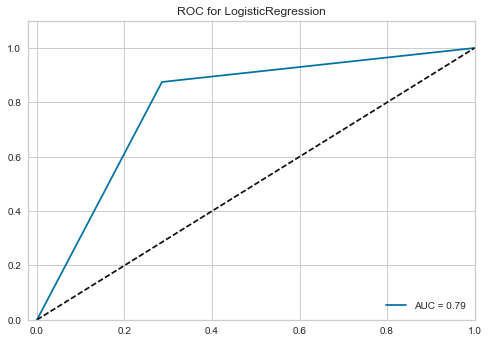

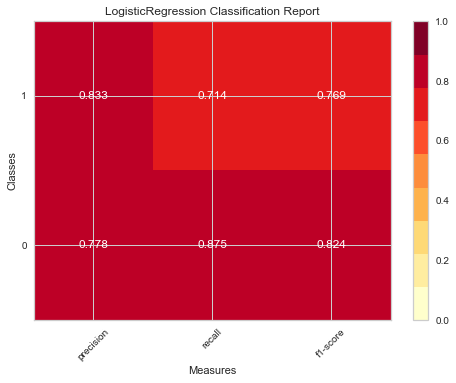

In [38]:
lr = LogisticRegression(C = 3.7, penalty='l1')
lr.fit(x_train, y_train)
prediction = lr.predict(x_test)
print('Our accuracy score: %f' %accuracy_score(y_test,prediction))

print('Confusion Matrix:')
print(confusion_matrix(y_test, prediction))



visualizer = ROCAUC(lr)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data 
r = visualizer.poof() 

classes = [1,0]
visualizer = ClassificationReport(lr, classes=classes)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data 
g = visualizer.poof() 

Sort of surprising result, and sensible one too. It is at least kind of predictable whether or not a state will use coal based on it's generation and affiliation. ROC is decent, as is precision and recall. Obviously it's not going to be great given the lack of data, but I'm accepting of this. Below I'll see how well simply being mostly conservative predicts coals use. I assume it'll be very close to the result we just obtained.

In [39]:
#Doing a grid search cross validation to figure out best way to do KNN.
#Here we are just seeing if political affiliation can predict, even decently, whether
#or not coal will be utilized.

param_grid = {'C': np.logspace(-5,8,15), 'penalty': ['l1','l2']}

lr = LogisticRegression()

X = coal_df['swing'].values.reshape(-1,1)


x_train, x_test, y_train, y_test = train_test_split(X, st_type.coal, test_size = .3)
lr_cv = GridSearchCV(lr, param_grid, cv = 5)
lr_cv.fit(x_train, y_train)

print("Tuned Knn classifier paramters: {}".format(lr_cv.best_params_))
print("Tuned Knn classifier score: {}".format(lr_cv.best_score_))

Tuned Knn classifier paramters: {'penalty': 'l1', 'C': 0.43939705607607948}
Tuned Knn classifier score: 0.771428571429


Our accuracy score: 0.600000
Cofusion Matrix:
[[3 4]
 [2 6]]


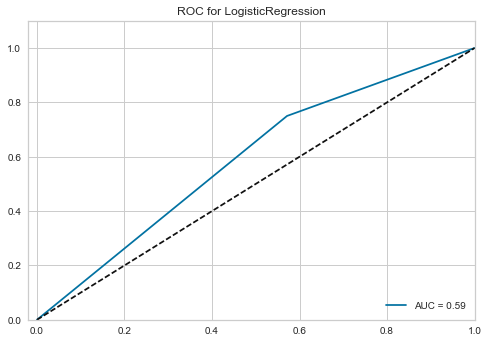

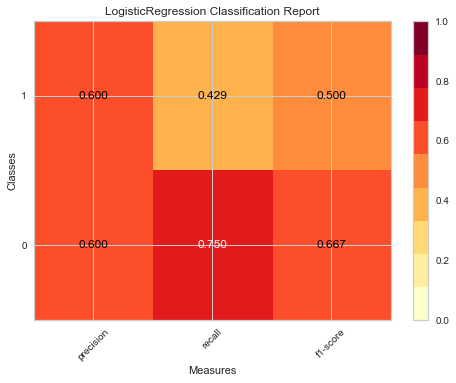

In [40]:
#Plugging in the best parameter from above
lr = LogisticRegression(C = .4394, penalty='l1')
lr.fit(x_train, y_train)
prediction = lr.predict(x_test)
print('Our accuracy score: %f' %accuracy_score(y_test,prediction))

print("Cofusion Matrix:")
print(confusion_matrix(y_test, prediction))



visualizer = ROCAUC(lr)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data 
r = visualizer.poof() 


classes = [1,0]
visualizer = ClassificationReport(lr, classes=classes)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data 
g = visualizer.poof() 

As expected, pretty similar. Looking at the confusion matrix, and drawing on inuition, I think this has more to do with smaller conservative states using coal more rather than liberal states using coal less. Still a cool comparison.

In [41]:
#To be thorough, we'll try to run the same analysis as above (can we predict inpout type by political affiliation)
#using a Support Vector Machine

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C':np.logspace(-2, 10, 13),
'gamma':np.logspace(-9, 3, 13)}

svm = SVC()

X = coal_df['swing'].values.reshape(-1,1)


x_train, x_test, y_train, y_test = train_test_split(X, st_type.coal, test_size = .3)
svm_cv = GridSearchCV(svm, param_grid, cv = 5)
svm_cv.fit(x_train, y_train)

print("Tuned SVM classifier paramters: {}".format(svm_cv.best_params_))
print("Tuned SVM classifier score: {}".format(svm_cv.best_score_))




Tuned SVM classifier paramters: {'C': 1.0, 'gamma': 1.0}
Tuned SVM classifier score: 0.714285714286


Our accuracy score: 0.733333
Cofusion Matrix:
[[4 3]
 [1 7]]


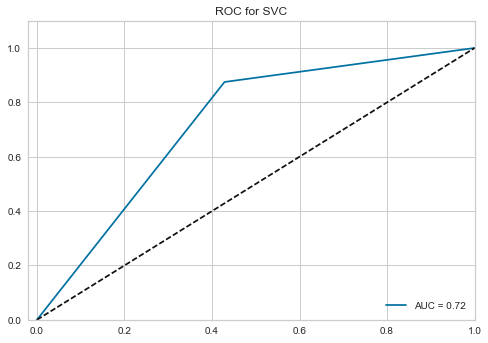

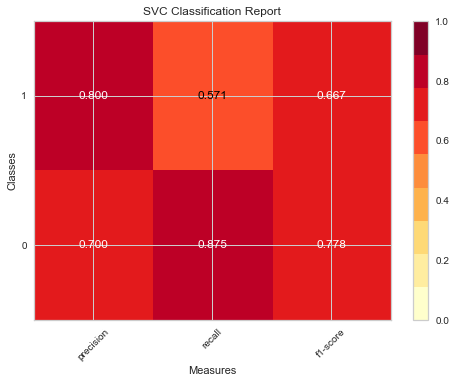

In [42]:
#Plugging in the best parameter from above
svm = SVC(C = 1, gamma = 1)
svm.fit(x_train, y_train)
prediction = svm.predict(x_test)
print('Our accuracy score: %f' %accuracy_score(y_test,prediction))

print("Cofusion Matrix:")

print(confusion_matrix(y_test, prediction))



visualizer = ROCAUC(svm)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data g = visualizer.poof() 
r=visualizer.poof()

classes = [1,0]
visualizer = ClassificationReport(svm, classes=classes)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data 
g = visualizer.poof() 

SVM does a decent job. Looks like our ROC/AUC is pretty good, and the confusion matrix tells us that things went ok on the accuracy front.

In [43]:
#Let's quickly compare to our Logistic Regression
svm_score = []
for i in range(1000):
    svm = SVC(C = 1, gamma = 1)
    svm.fit(x_train, y_train)
    prediction = svm.predict(x_test)
    svm_score.append(accuracy_score(y_test,prediction))

In [44]:
diff_of_means = np.mean(svm_score)-np.mean(score_none)
array = score_none+for_score
rand_scores = np.random.permutation(array)
new_diff = rand_scores[0:1000] - rand_scores[1000:]

p = np.sum((new_diff>=diff_of_means))
print p


172


SVM seems to be better than a logistic model at the 85% confidence interval. Seemed to do about the same as the Random Forest, which isn't entirely surprising given how simple this model is, and how well a binomial classifier could likely handle this. I think as we add data and features our Forest would excel.

Now that we've got an idea for what's happening from state to state, I want to see what Coal's regression looks like.

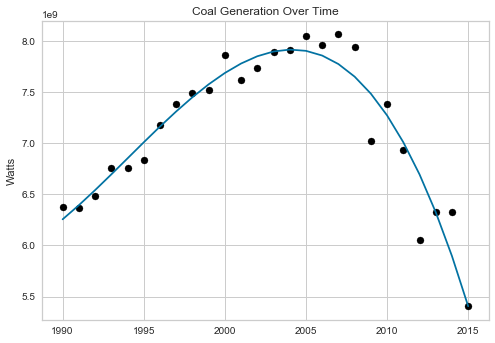

In [45]:
#Plotting Coal
p,res,_,_,_ = np.polyfit(inp.year, inp.Coal, deg = 3, full=True)
yfitcoal = np.polyval(p,inp.year)
figure()
plt.scatter(inp.year, inp.Coal, label = 'data', c = 'black')
plt.plot(inp.year, yfitcoal, label = 'fit')
plt.title('Coal Generation Over Time')
plt.ylabel('Watts')
plt.savefig('Coal', transparent = True)

Without really needing to do any analysis, it looks like coal is declining, and has been for some time. Drawing on my energy economics background, I can tell you that while we're just now hearing about the death of coal and policies around killing coal, it's actually been on it's way our for the last 10-15 years (pre-Obama even). Coal stopped being economically viable when natural gas hydraulic fracturing and shale became pervasive, and while those have a host of their own problems, we can at least have clean(er) air to accompany our "dirty water".

Not surpisingly, natural gas has been climbing at an increasing rate for as long as our data can show.

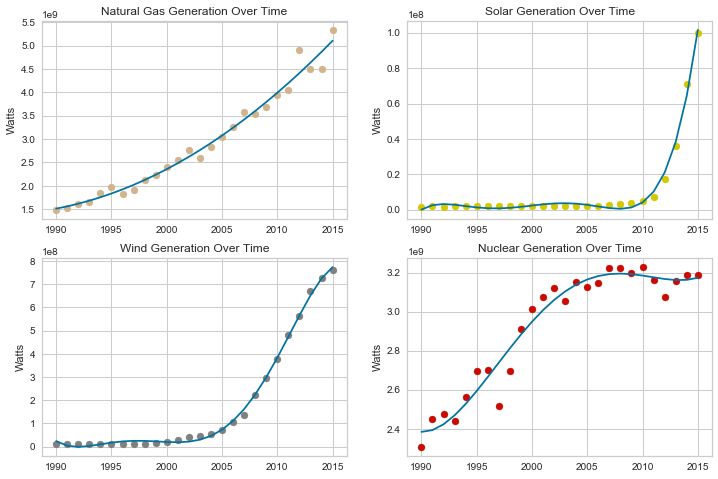

In [46]:
figure()
fig = plt.figure(figsize=(12, 8)) 

#Plotting Natural Gas
p,res,_,_,_ = np.polyfit(inp.year, inp['Natural Gas'], deg = 2, full=True)
yfitcoal = np.polyval(p,inp.year)
plt.subplot(2,2,1)
plt.scatter(inp.year, inp['Natural Gas'], label = 'data', c = 'tan')
plt.plot(inp.year, yfitcoal, label = 'fit', linestyle = '-')
plt.title('Natural Gas Generation Over Time')
plt.ylabel('Watts')


#Plottinh Solar
p,res,_,_,_ = np.polyfit(inp.year, inp['Solar Thermal and Photovoltaic'], deg = 5, full=True)
yfitcoal = np.polyval(p,inp.year)
plt.subplot(2,2,2)
plt.scatter(inp.year, inp['Solar Thermal and Photovoltaic'], label = 'data',c = 'y')
plt.plot(inp.year, yfitcoal, label = 'fit')
plt.title('Solar Generation Over Time')
plt.ylabel('Watts')


#Plotting Wind
p,res,_,_,_ = np.polyfit(inp.year, inp['Wind'], deg = 5, full=True)
yfitcoal = np.polyval(p,inp.year)
plt.subplot(2,2,3)
plt.scatter(inp.year, inp['Wind'], label = 'data', c = 'gray')
plt.plot(inp.year, yfitcoal, label = 'fit')
plt.title('Wind Generation Over Time')
plt.ylabel('Watts')


#Plotting Nuclear
p,res,_,_,_ = np.polyfit(inp.year, inp['Nuclear'], deg = 4, full=True)
yfitcoal = np.polyval(p,inp.year)
plt.subplot(2,2,4)
plt.scatter(inp.year, inp['Nuclear'], label = 'data', c = 'r')
plt.plot(inp.year, yfitcoal, label = 'fit')
plt.title('Nuclear Generation Over Time')
plt.ylabel('Watts')


Not surpisingly, natural gas has been climbing at an increasing rate for as long as our data can show. All the other's seem to be on the rise as well. Nuclear took a hit with Fukushima, but is slowly coming back into the foreground of generation.